In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import warnings

# Tắt các cảnh báo không quan trọng
warnings.filterwarnings('ignore')

# Cài đặt để Matplotlib hiển thị biểu đồ ngay trong notebook
%matplotlib inline

In [21]:
# --- Bước 1: Tải và Khám phá Dữ liệu ---
print("--- Bước 1: Tải và Khám phá Dữ liệu ---")
try:
    data = pd.read_csv('./data/train.csv')
    print("Tải dữ liệu 'train.csv' thành công!")
    
    print("\n5 dòng dữ liệu đầu tiên:")
    display(data.head())
    
    print("\nThông tin chung về dữ liệu:")
    data.info()
    
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp 'train.csv'.")
    data = None

--- Bước 1: Tải và Khám phá Dữ liệu ---
Tải dữ liệu 'train.csv' thành công!

5 dòng dữ liệu đầu tiên:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Thông tin chung về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [23]:
# --- Bước 2: Tiền xử lý dữ liệu ---

def preprocess_data(df):
    # Sao chép để tránh thay đổi dữ liệu gốc
    df_processed = df.copy()
    
    # 1. Xử lý giá trị thiếu (Missing Values)
    # Age: Điền giá trị tuổi bị thiếu bằng giá trị trung vị (median)
    df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
    
    # Embarked: Điền giá trị bị thiếu bằng giá trị xuất hiện nhiều nhất (mode)
    df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])
    
    # 2. Mã hóa các biến phân loại (Encoding Categorical Variables)
    # Sex: Chuyển 'male' -> 0, 'female' -> 1
    df_processed['Sex'] = df_processed['Sex'].map({'male': 0, 'female': 1}).astype(int)
    
    # Embarked: Dùng One-Hot Encoding
    df_processed = pd.get_dummies(df_processed, columns=['Embarked'], drop_first=True)
    
    # 3. Bỏ các cột không cần thiết cho mô hình
    # PassengerId không phải là đặc trưng, Name và Ticket quá phức tạp, Cabin thiếu quá nhiều
    cols_to_drop = ['Name', 'Ticket', 'PassengerId', 'Cabin']
    df_processed = df_processed.drop(columns=cols_to_drop, axis=1)
    
    return df_processed

# Áp dụng hàm tiền xử lý
data_processed = preprocess_data(data)
print("Tiền xử lý dữ liệu thành công.")
print("Dữ liệu sau khi xử lý (5 dòng đầu):")
display(data_processed.head())

Tiền xử lý dữ liệu thành công.
Dữ liệu sau khi xử lý (5 dòng đầu):


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,True
1,1,1,1,38.0,1,0,71.2833,False,False
2,1,3,1,26.0,0,0,7.9250,False,True
3,1,1,1,35.0,1,0,53.1000,False,True
4,0,3,0,35.0,0,0,8.0500,False,True


In [25]:
# --- Bước 3: Chuẩn bị dữ liệu cho tập Train và Test ---
print("\n--- Bước 3: Chuẩn bị dữ liệu (Train/Test Split) ---")

# Tách X (đặc trưng) và y (mục tiêu)
X = data_processed.drop('Survived', axis=1)
y = data_processed['Survived']

# Lấy tên các đặc trưng để sử dụng sau này
feature_names = X.columns.tolist() 

# Chia dữ liệu (tương tự Nhiệm vụ 1, bước 3 trong tài liệu)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")
print(f"Kích thước nhãn huấn luyện (y_train): {y_train.shape}")
print(f"Kích thước nhãn kiểm tra (y_test): {y_test.shape}")


--- Bước 3: Chuẩn bị dữ liệu (Train/Test Split) ---
Kích thước tập huấn luyện (X_train): (712, 8)
Kích thước tập kiểm tra (X_test): (179, 8)
Kích thước nhãn huấn luyện (y_train): (712,)
Kích thước nhãn kiểm tra (y_test): (179,)



--- Nhiệm vụ A: Xây dựng Cây quyết định ---
Độ chính xác (Accuracy) của Cây quyết định: 0.7989

Đang vẽ cây quyết định bằng plot_tree của Scikit-learn...


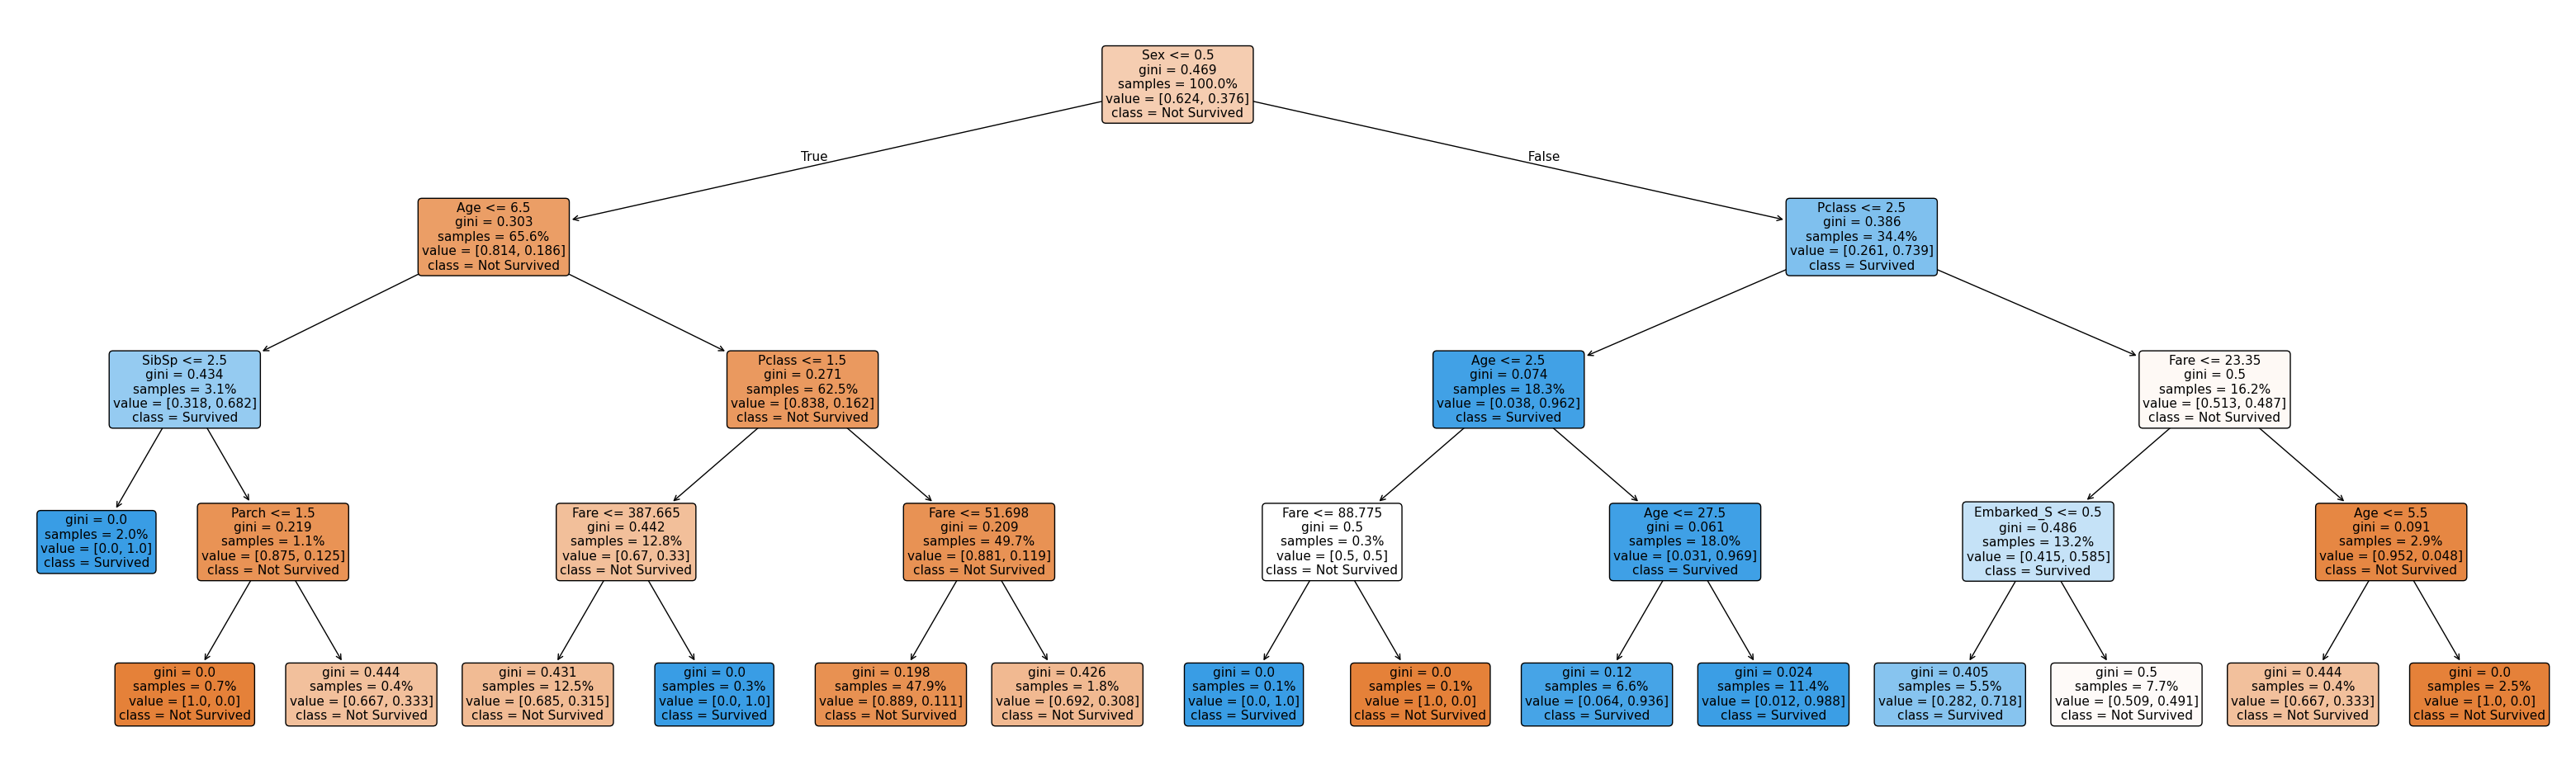

In [53]:
# --- Nhiệm vụ A: Xây dựng Cây quyết định (Decision Tree) ---
print("\n--- Nhiệm vụ A: Xây dựng Cây quyết định ---")

# Import thêm hàm plot_tree
from sklearn.tree import plot_tree

# 1. Xây dựng cây với độ sâu giới hạn (max_depth=4)
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

# 2. Đánh giá mô hình
y_pred_dt = dt_model.predict(X_test)
print(f"Độ chính xác (Accuracy) của Cây quyết định: {accuracy_score(y_test, y_pred_dt):.4f}")

# 3. Hiển thị cây quyết định bằng sklearn.tree.plot_tree (dùng Matplotlib)
print("\nĐang vẽ cây quyết định bằng plot_tree của Scikit-learn...")

# Tạo một figure của matplotlib để kiểm soát kích thước
plt.figure(figsize=(40, 12)) # Bạn có thể điều chỉnh (rộng, cao)

plot_tree(dt_model, 
          feature_names=feature_names, 
          class_names=['Not Survived', 'Survived'],
          filled=True,     # Tô màu các ô
          rounded=True,    # Bo tròn góc ô
          proportion=True, # Hiển thị tỷ lệ (giống tài liệu)
          fontsize=11)     # Cỡ chữ

# Lưu hình ảnh nếu bạn muốn (giống như bài mẫu)
plt.savefig("titanic_decision_tree_plot_tree.png")

# Hiển thị biểu đồ ngay tại cell output
plt.show()

In [29]:
# --- Nhiệm vụ B: Xây dựng Rừng cây (Random Forest) và Tối ưu hóa (GridSearchCV) ---
print("\n--- Nhiệm vụ B: Xây dựng Rừng cây & Tối ưu hóa ---")

# 1. Tạo mô hình
rf_model = RandomForestClassifier(random_state=42)

# 2. Định nghĩa các tham số để tối ưu (tương tự Nhiệm vụ 2 trong tài liệu)
params_grid = {
    'n_estimators': [50, 100, 150],  # Số lượng cây
    'max_depth': [3, 5, 7, 10]     # Độ sâu tối đa của mỗi cây
}

# 3. Sử dụng GridSearchCV để tìm tham số tối ưu (scoring='accuracy')
# cv=4 nghĩa là 4-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, 
                            param_grid=params_grid, 
                            cv=4, 
                            scoring='accuracy', 
                            verbose=1,
                            n_jobs=-1) # Sử dụng tất cả các nhân CPU

print("Bắt đầu huấn luyện GridSearchCV...")
grid_search_rf.fit(X_train, y_train)
print("Huấn luyện GridSearchCV hoàn tất.")

# 4. In ra tham số tốt nhất
print(f"\nTham số Rừng cây tốt nhất tìm được: {grid_search_rf.best_params_}")

# 5. Đánh giá mô hình tốt nhất
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"Độ chính xác (Accuracy) của Rừng cây tốt nhất: {accuracy_score(y_test, y_pred_rf):.4f}")

print("\nBáo cáo phân loại (Classification Report) của Rừng cây:")
print(classification_report(y_test, y_pred_rf, target_names=['Not Survived', 'Survived']))


--- Nhiệm vụ B: Xây dựng Rừng cây & Tối ưu hóa ---
Bắt đầu huấn luyện GridSearchCV...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Huấn luyện GridSearchCV hoàn tất.

Tham số Rừng cây tốt nhất tìm được: {'max_depth': 5, 'n_estimators': 150}
Độ chính xác (Accuracy) của Rừng cây tốt nhất: 0.8101

Báo cáo phân loại (Classification Report) của Rừng cây:
              precision    recall  f1-score   support

Not Survived       0.81      0.89      0.85       105
    Survived       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179




--- Phân tích mức độ quan trọng của đặc trưng ---
Mức độ quan trọng của các đặc trưng (sắp xếp giảm dần):


,Importance
Sex,0.447435
Fare,0.191670
Pclass,0.131700
Age,0.107655
SibSp,0.050089
Parch,0.038635
Embarked_S,0.024474
Embarked_Q,0.008342


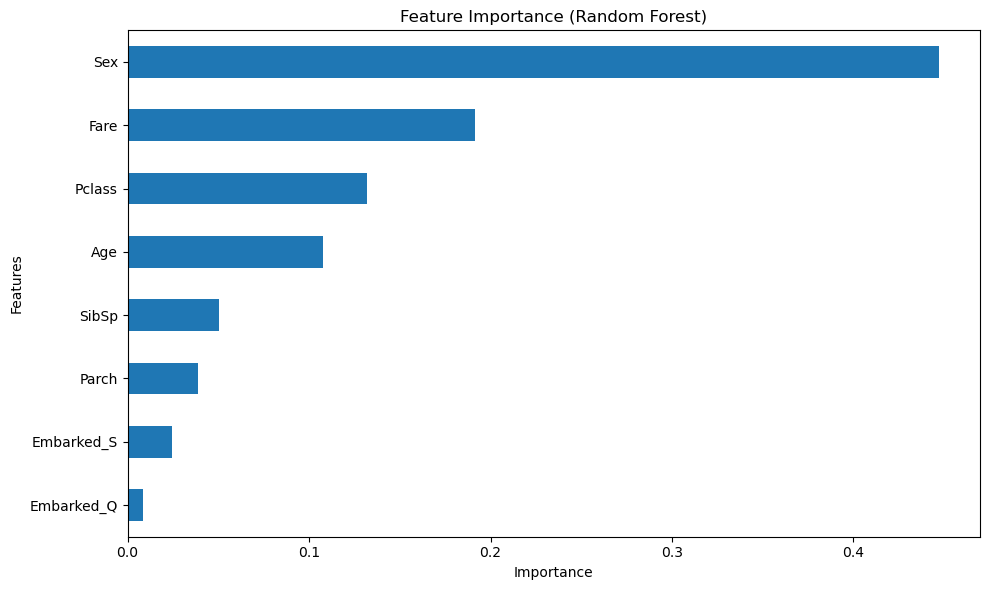

In [30]:
# --- Phân tích mức độ quan trọng của đặc trưng ---
# (Tương tự Hình 2.4 trong tài liệu)
print("\n--- Phân tích mức độ quan trọng của đặc trưng ---")

# 1. Lấy dữ liệu
feat_imp_df = pd.DataFrame({
    'Importance': best_rf.feature_importances_},
    index=feature_names
)

# Sắp xếp để vẽ biểu đồ
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)
print("Mức độ quan trọng của các đặc trưng (sắp xếp giảm dần):")
display(feat_imp_df)

# 2. Vẽ biểu đồ Barh
plt.figure(figsize=(10, 6))
# Sắp xếp tăng dần để hiển thị đặc trưng quan trọng nhất ở trên cùng
feat_imp_df.sort_values('Importance', ascending=True).plot(kind='barh', legend=False, ax=plt.gca())
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
# Lưu biểu đồ nếu muốn
plt.savefig('titanic_feature_importance.png')
plt.show()